Nesse último trabalho, nós vamos utilizar o MLP e o ELM para resolver problemas de regressão.

A performance do modelo deve ser baseado no cálculo do RMSE - tanto no treino quanto no teste. Também vamos plotar um gráfico de predição 3D.

Serão 500 amostras para treino e teste.

A função alvo é definida por:
$$y(x_1, x_2) = sin^2(x_1) * cos^2(x_2) + x_1*x_2^3$$

In [2]:
# Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Só com hiperparâmetros absurdos para o MLP que eu consegui resultados um pouco melhores. O professor falou que era para o erro ser abaixo de 1, mas não consegui de nenhuma maneira.

In [50]:
L_INF = -np.pi
L_SUP = np.pi
TOTAL_SAMPLES = 500

GRID_SIZE = 30
NUM_ROUNDS = 50

HIDDEN_DIM = 100
LEARNING_RATE_MLP = 0.1
EPOCHS_MLP = 5000

# Definição dos modelos

A distância euclidiana será utilizada nos dois modelos.

In [51]:
def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return 1 - np.tanh(x)**2

In [52]:
class MLP:
  def __init__(self, input_dim, hidden_dim, output_dim, lr):
    self.w1 = np.random.uniform(-1, 1, (input_dim, hidden_dim))
    self.b1 = np.zeros((1, hidden_dim))
    self.w2 = np.random.uniform(-1, 1, (hidden_dim, output_dim))
    self.b2 = np.zeros((1, output_dim))
    self.lr = lr

  def fit(self, X, y, epochs):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    n = X.shape[0]

    for _ in range(epochs):
      z1 = X @ self.w1 + self.b1
      a1 = tanh(z1)
      z2 = a1 @ self.w2 + self.b2

      # Backward
      error = z2 - y

      d_w2 = a1.T @ error / n
      d_b2 = np.sum(error, axis=0, keepdims=True) / n

      delta_hidden = error @ self.w2.T * tanh_derivative(z1)
      d_w1 = X.T @ delta_hidden / n
      d_b1 = np.sum(delta_hidden, axis=0, keepdims=True) / n

      # Atualização dos pesos
      self.w2 -= self.lr * d_w2
      self.b2 -= self.lr * d_b2
      self.w1 -= self.lr * d_w1
      self.b1 -= self.lr * d_b1

  def predict(self, X):
    z1 = X @ self.w1 + self.b1
    a1 = tanh(z1)
    return a1 @ self.w2 + self.b2

In [53]:
class ELM:
  def __init__(self, input_dim, hidden_dim):
    self.W = np.random.uniform(-1, 1, (input_dim, hidden_dim))
    self.b = np.random.uniform(-1, 1, (1, hidden_dim))
    self.beta = None

  def fit(self, X, y):
    H = tanh(X @ self.W + self.b)
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    self.beta = np.linalg.pinv(H) @ y

  def predict(self, X):
    H = tanh(X @ self.W + self.b)
    return H @ self.beta

# Dataset

In [54]:
def train_test_split(X, y, test_size=0.2, random_state=None):
  if random_state is not None:
      np.random.seed(random_state)
  n_samples = len(X)
  shuffled_indices = np.random.permutation(n_samples)
  test_size = int(n_samples * test_size)
  test_indices = shuffled_indices[:test_size]
  train_indices = shuffled_indices[test_size:]
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]
  return X_train, X_test, y_train, y_test, train_indices, test_indices

Dessa vez, precisaremos normalizar e desnormalizar os dados para testar o modelo. Por isso, é melhor criar uma classe só para isso.

In [55]:
class Scaler:
  def __init__(self, feature_range=(-1, 1)):
    self.feature_range = feature_range
    self.min_val_ = None
    self.scale_ = None

  def fit_transform(self, data):
    self.min_val_ = data.min(axis=0)
    self.scale_ = data.max(axis=0) - self.min_val_
    self.scale_[self.scale_ == 0] = 1.0
    return self.transform(data)

  def transform(self, data):
    data_std = (data - self.min_val_) / self.scale_
    return data_std * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]

  def inverse_transform(self, data):
    data_std = (data - self.feature_range[0]) / (self.feature_range[1] - self.feature_range[0])
    return data_std * self.scale_ + self.min_val_

# Métricas

In [56]:
def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

In [57]:
def rmse(y_true, y_pred):
  return np.sqrt(np.mean((y_true - y_pred)**2))

# Execução

In [58]:
def target_function(X):
  x1, x2 = X[:, 0], X[:, 1]
  return np.sin(x1)**2 * np.cos(x2) + x1 * x2**3

In [59]:
np.random.seed(42)
X_raw = np.random.uniform(L_INF, L_SUP, (TOTAL_SAMPLES, 2))
y_raw = target_function(X_raw).reshape(-1, 1)

In [60]:
x_scaler = Scaler()
y_scaler = Scaler()

X_norm = x_scaler.fit_transform(X_raw)
y_norm = y_scaler.fit_transform(y_raw)

results = {"ELM": {"rmse_train": [], "rmse_test": []},
           "MLP": {"rmse_train": [], "rmse_test": []}}

for i in range(NUM_ROUNDS):
  X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_norm, y_norm, random_state=i)

  y_train_raw = y_raw[train_indices]
  y_test_raw = y_raw[test_indices]

  models = {
    "MLP": MLP(X_train.shape[1], HIDDEN_DIM, 1, LEARNING_RATE_MLP),
    "ELM": ELM(X_train.shape[1], HIDDEN_DIM)
  }

  for name, model in models.items():
    if name == 'MLP':
      model.fit(X_train, y_train, EPOCHS_MLP)
    else:
      model.fit(X_train, y_train)

    y_pred_train_norm = model.predict(X_train)
    y_pred_train_raw = y_scaler.inverse_transform(y_pred_train_norm)
    rmse_train = rmse(y_train_raw, y_pred_train_raw)
    results[name]['rmse_train'].append(rmse_train)

    y_pred_test_norm = model.predict(X_test)
    y_pred_test_raw = y_scaler.inverse_transform(y_pred_test_norm)
    rmse_test = rmse(y_test_raw, y_pred_test_raw)
    results[name]['rmse_test'].append(rmse_test)

df_results = pd.DataFrame({
    "Model": ["ELM", "MLP"],
    "Mean RMSE on Train": [np.mean(results['ELM']['rmse_train']), np.mean(results['MLP']['rmse_train'])],
    "Mean RMSE on Test": [np.mean(results['ELM']['rmse_test']), np.mean(results['MLP']['rmse_test'])],
})
print(df_results.round(4))

  Model  Mean RMSE on Train  Mean RMSE on Test
0   ELM              0.0003             0.0018
1   MLP              5.9848             6.6282


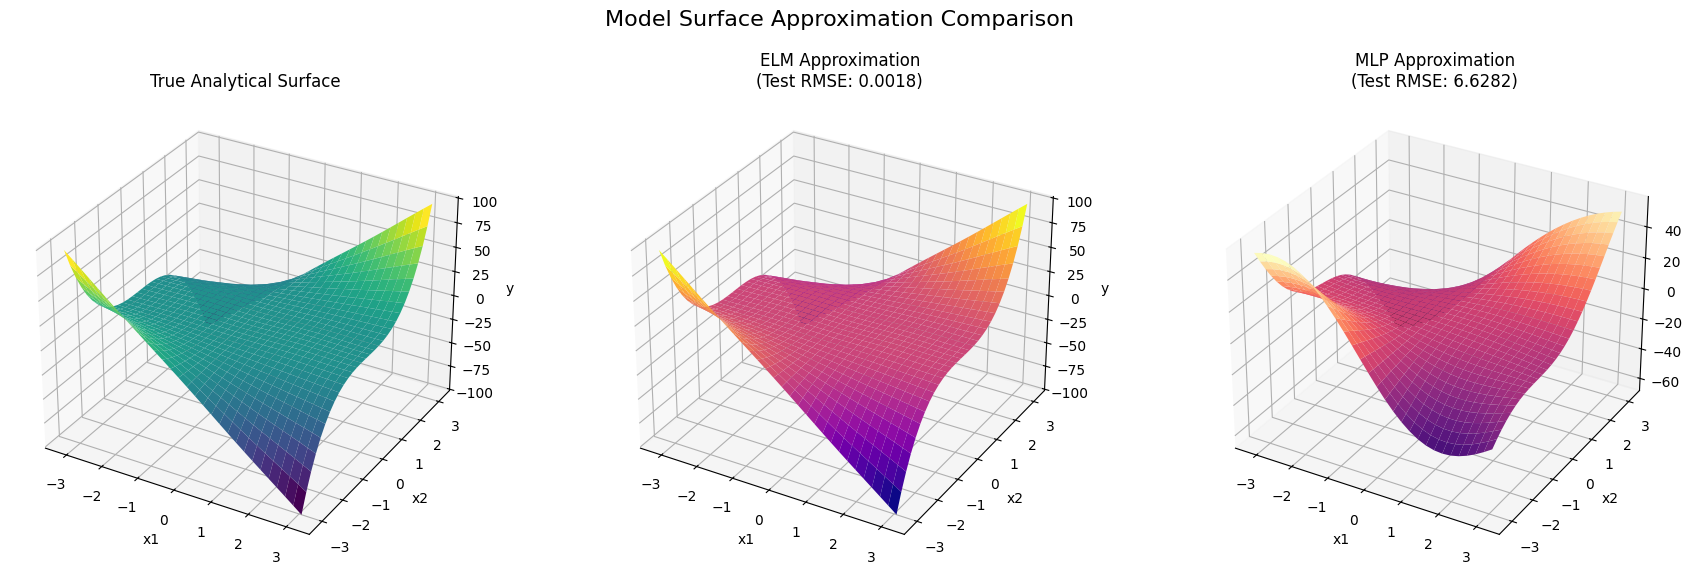

In [61]:
# Grid para plotagem
x1_lin = np.linspace(L_INF, L_SUP, GRID_SIZE)
x2_lin = np.linspace(L_INF, L_SUP, GRID_SIZE)
X1_grid, X2_grid = np.meshgrid(x1_lin, x2_lin)
X_grid_raw = np.column_stack((X1_grid.ravel(), X2_grid.ravel()))
Z_true = target_function(X_grid_raw).reshape(GRID_SIZE, GRID_SIZE)

X_grid_norm = x_scaler.transform(X_grid_raw)

Z_elm_norm = models['ELM'].predict(X_grid_norm)
Z_elm = y_scaler.inverse_transform(Z_elm_norm).reshape(GRID_SIZE, GRID_SIZE)

Z_mlp_norm = models['MLP'].predict(X_grid_norm)
Z_mlp = y_scaler.inverse_transform(Z_mlp_norm).reshape(GRID_SIZE, GRID_SIZE)

fig = plt.figure(figsize=(18, 6))
plt.suptitle("Model Surface Approximation Comparison", fontsize=16)

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X1_grid, X2_grid, Z_true, cmap='viridis')
ax1.set_title('True Analytical Surface')
ax1.set_xlabel('x1'); ax1.set_ylabel('x2'); ax1.set_zlabel('y')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X1_grid, X2_grid, Z_elm, cmap='plasma')
ax2.set_title(f'ELM Approximation\n(Test RMSE: {df_results["Mean RMSE on Test"][0]:.4f})')
ax2.set_xlabel('x1'); ax2.set_ylabel('x2'); ax2.set_zlabel('y')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X1_grid, X2_grid, Z_mlp, cmap='magma')
ax3.set_title(f'MLP Approximation\n(Test RMSE: {df_results["Mean RMSE on Test"][1]:.4f})')
ax3.set_xlabel('x1'); ax3.set_ylabel('x2'); ax3.set_zlabel('y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Essa aqui não é a melhor maneira de visualizar e comparar os modelos, mas como não é possível criar uma janela interativa no colab, deixei assim.